# Exercise 4

Exercise 4 includes a **written assignment** (10 points), a **programming assignment with 5 problems** (9 points) and a **feedback/workload assessment assignment** (1 point). For each problem you need to modify the notebook by adding your own programming solutions or written text. Remember to save and commit your changes locally, and push your changes to GitHub after each major change! Regular commits will help you to keep track of your changes (and revert them if needed). Pushing your work to GitHub will ensure that you don't lose any work in case your computer crashes (can happen!).

### Due date

This exercise should be returned to your personal Github repository **within two weeks** after it has been released (by Thursday February 17th at 23:59). Please notice that finishing the programming exercises can take significant amount of time (especially if you don't have yet much programming experience). Hence, it is recommended that you start immediately working on them.

# Exercise 4 - Written assignment (10 points)

In the "Economic inequalities, growth and green economy" and the "Spatial regression" lessons + tutorial 
this week, we went through different indicators that can be used to understand economic inequalities and how 
(spatial) regression models can be used e.g. to understand which factors influence pricing of Airbnb listings. 

Write 0.5-2 pages (A4) of text in English where you explain:
 
 - What are the key characteristics of different indicators that aim to measure economic inequality in the world?
 - Why growth/progress indicators that focus purely on economic performance are problematic? 
 - Why is it important to take spatial effects into account when doing regression analysis? 
 - What two approaches did we use to consider spatial effects in the tutorial? How do they differ? 
 
Use the lesson materials and the recommended readings (optional) as a source of information for answering to these.

----------------

## My answer

Add your text here.

*Hint: To "activate" this cell in Editing mode, double click this cell. If you want to get this cell back in the "Reading-mode", press Shift+Enter.*


## Hints

- If you need help in Markdown formatting (e.g. how to add headings, bold, italics, links etc.), please take a look at this excellent [guide / cheatsheet](https://www.markdownguide.org/cheat-sheet/) 


# Exercise 4 - Programming assignment (9 points)

In this exercise, we practice doing spatial regression using postal code level data from Finland that is openly available via Statistics Finland. We aim to understand what factors influence the housing prices in Helsinki Region. In this exercise, you will learn how to:

 - investigate linear relationship between different attributes
 - create spatial weights using pysal library
 - investigate spatial autocorrelation in the data using Moran's I indicator
 - conduct Ordinary Least Squares regression and spatial regression models using pysal library 


### Due date

The exercise should be returned by the end of Friday (19th of February, 2021).  

### Start your exercise in CSC Notebooks

Before you can start programming, you need to launch the CSC Notebook instance and clone your Exercise repository there.
If you need help with this, [read the documentation on the course site](https://sustainability-gis.readthedocs.io/en/latest/lessons/L1/git-basics.html).
 
### Hints 

If there are general questions arising from this exercise, we will add hints to the course website under [Exercise 4 description](https://sustainability-gis.readthedocs.io/en/latest/lessons/L4/exercise-4.html). 

## Input data

In this Exercise, we will use openly available postal code level data from Statistics Finland. We use two different datasets: 
  1. [Paavo postal code level data](https://www.stat.fi/tup/paavo/paavon_aineistokuvaukset_en.html) - Provides us many useful attributes that we can use as explanatory variables in our linear regression models.  
  2. [Average prices of dwellings](https://www.stat.fi/til/ashi/index_en.html) in housing companies in Finland (€ per square meter)
  3. OpenStreetMap data - Provides us street network data that we use to calculate an accessibility index for each postal code area which is used as one explanatory variable

## Hypothesis

In this exercise, we hypothesize that following attributes might explain the average apartment price on a postal code level:

 1. Distance to city center
 2. Number of jobs in the area
 3. Number of people living in the area with higher education degree
 4. Average size of the households (i.e. how many people live in an household)
 5. Average income of the households
 
In addition to these, we finally consider using a spatial lag model that:

 6. The average price of the neighboring areas influences the price on a given area


## Problem 1 - Prepare data (1 point)

In this problem you should:

1. Read the postal code level data from Statistics Finland and select the data for Helsinki Region based on municipality code (`kunta`)
2. Remove unnecessary columns by selecting only following attributes from the postal code data:

  - tp_tyopy --> Number of jobs in the area (total)
  - ko_yl_kork --> Number of people having higher education degree
  - te_takk --> Average size of the households
  - tr_ktu --> Average income of the households


3. Read the apartment price data from `apartment_prices_finland_2019.csv` file which is located in the `data` directory (when reading the data, ensure that the data type of the `postal_code` attribute is string. Hint: Check the pandas documentation for read_csv() and the parameter `dtype`. 

4. Make a table join between the postal code dataset and the apartment price dataset based on the `posti_alue` and `postal_code` attributes. 
5. Investigate your data. Are there missing values in any of the selected attributes? If there are:

  - remove NaN values
  - reset the index

6. Make map out of the average price per square meter in Helsinki Region. As a result you should have something like following:

![Average housing prices](img/housing_prices.PNG)


<AxesSubplot:>

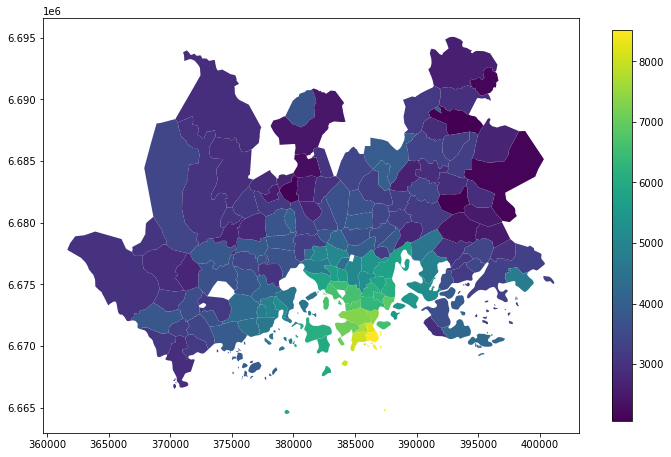

In [39]:
import geopandas as gpd
import pandas as pd

# URL for postal code level data from Statistics Finland
url = "http://geo.stat.fi/geoserver/postialue/wfs?request=GetFeature&typename=postialue:pno_tilasto_2019&outputformat=JSON"

# YOUR CODE HERE
# 1. Read the postal code level data from Statistics Finland and select the data for Helsinki Region based on municipality code (kunta)
postal = gpd.read_file(url)
postal = postal.loc[postal["kunta"].isin(['235', '049', '091', '092'])].copy()

# 2. Remove unnecessary columns by selecting only following attributes from the postal code data:
    # tp_tyopy --> Number of jobs in the area (total)
    # ko_yl_kork --> Number of people having higher education degree
    # te_takk --> Average size of the households
    # tr_ktu --> Average income of the households
postal = postal[["posti_alue", "tp_tyopy", "ko_yl_kork", "te_takk", "tr_ktu", "geometry"]]

# 3. Read the apartment price data from apartment_prices_finland_2019.csv file which is located in the data directory
price = pd.read_csv("data/apartment_prices_finland_2019.csv", dtype={"postal_code":"str"})

# 4. Make a table join between the postal code dataset and the apartment price dataset based on the posti_alue and postal_code attributes.
data = pd.merge(left=postal, right=price, how="inner", left_on="posti_alue", right_on="postal_code")

# 5. Investigate your data. Are there missing values in any of the selected attributes? If there are:
# remove NaN values
data.dropna(inplace=True)
# reset the index
data.reset_index(inplace=True)
    
# 6. Make map out of the average price per square meter in Helsinki Region. As a result you should have something like following:
data.plot("avg_m2_price_2019", figsize=(12,12), cmap="viridis", legend=True, legend_kwds={'shrink': 0.6})


## Problem 2 - Create an accessibility index for each postal code area (2 points)

In this problem, the idea is to create an accessibility index for our postal code areas based on the network distance to the Helsinki city center. You should:

1. Calculate network distance from all postal code area centroids to the Helsinki Railway station --> Use pyrosm, NetworkX and OSMnx as we have learned during previous weeks. Sanity check: if you plot the network distances against the price information (as a scatter plot, check [Seaborn lmplot()](https://seaborn.pydata.org/generated/seaborn.lmplot.html)), you should get something like below:

![Network distances agains Housing prices](img/price_against_distance.PNG)

2. Create an accessibility index as a new column called `access_index` in which you should:
  
  - Calculate the inverse distance with formula: `abs( distance - max(distance) )`
  - Standarize the inversed distance to scale 0-1 with formula: `inverse_distance / max(inverse_distance)`

As a result for the accessibility index, you should have something like following:

![Accessibility index](img/access_index.PNG)

In [26]:
from pyrosm import OSM, get_data
import networkx as nx
import osmnx as ox 
import seaborn

# YOUR CODE HERE

# 1. Calculate network distance from all postal code area centroids to the Helsinki Railway station --> Use pyrosm, NetworkX and OSMnx as we have learned during previous weeks. 
osm = OSM(get_data("helsinki"))
nodes, edges = osm.get_network(network_type="driving", nodes=True)
edges = edges[["length", "u", "v", "geometry"]]
G = osm.to_graph(nodes, edges, graph_type="networkx")


/opt/conda/lib/python3.9/site-packages/pyrosm/graphs.py:155: UserWarning: Column 'oneway' missing in the edges GeoDataFrame. Assuming all edges to be bidirectional (travel allowed to both directions).
  nodes, edges = get_directed_edges(


In [41]:
data["centroid"] = data["geometry"].centroid

orig_address = "Rautatientori, Helsinki"
orig_y, orig_x = ox.geocode(orig_address)
orig_node_id = ox.distance.nearest_nodes(G, X=orig_x, Y=orig_y, return_dist=False)
results = []
for idx, row in data.iterrows():
    dest_node_id = ox.distance.nearest_nodes(G, X=row["centroid"].x, Y=row["centroid"].y, return_dist=False)
    travel_length = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='length')
    row["travel_length"] = travel_length
    print(row)
    if idx == 0:
        break

#travel_lengths_df = pd.DataFrame([list(travel_lengths.keys()), list(travel_lengths.values())]).T
#travel_lengths_df.columns = ['node_id', 'travel_length']


# Sanity check: if you plot the network distances against the price information (as a scatter plot, check Seaborn lmplot()), you should get something like below:
#seaborn.lmplot(x="travel_length", y="avg_m2_price_2019", data=data)

# 2. Create an accessibility index as a new column called access_index in which you should:
# Calculate the inverse distance with formula: abs( distance - max(distance) )
# Standarize the inversed distance to scale 0-1 with formula: inverse_distance / max(inverse_distance)
# As a result for the accessibility index, you should have something like following:


index                                                                0
posti_alue                                                       00100
tp_tyopy                                                       48470.0
ko_yl_kork                                                      5704.0
te_takk                                                            1.8
tr_ktu                                                         61679.0
geometry             (POLYGON ((385653.8928 6671591.0475, 385573.61...
postal_code                                                      00100
avg_m2_price_2019                                               7336.0
centroid                   POINT (385114.0020316057 6672390.769201209)
travel_length                                                21160.963
Name: 0, dtype: object


/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/opt/conda/lib/python3.9/site-packages/pandas/io/formats/printing.py:118: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(seq)
/opt/conda/lib/python3.9/site-packages/pandas/io/formats/printing.p

## Problem 3 - Make a correlation matrix (1 points)

In this problem, we start our statistical analysis by investigating the correlation between the price and the variables we have selected. One of the assumptions of Ordinary Least Squares regression is that there should be linear relationship betweem variables. Hence, before doing anything else, it is good to check whether this assumption You should:

1. Calculate a correlation matrix between all the variables in our model (i.e. price, access_index, tp_tyopy, ko_yl_kork, te_takk, tr_ktu) and store the result in a new DataFrame called `correlation_matrix`. Round the values so that they have only 2 decimals. Hint: Check the pandas documentation for `corr()` method.
2. Visualize the correlation matrix as a heatmap using Seaborn's [heatmap()](https://seaborn.pydata.org/generated/seaborn.heatmap.html) functionality. You should annotate the correlation values so that they are visible in the plot, and answer to following questions:

  - Which three (3) variables have the strongest correlation with price, and what are their correlation coefficients?
  - Which variable you might want to drop due to low correlation with price? (Note: do not drop the variable from your data, only answer to the question based on your understanding)
  - Multicollinearity should be avoided in OLS, meaning that there shouldn't be a relationship between the explanatory variables. One way to detect multicollinearity is to investigate whether there are high correlation values between the explanatory variables (a typical "rule of thumb" cutoff value is 0.8, although lower thresholds are used as well). Based on the correlation matrix, do you see issues with multicollinearity in our variables? Justify your answer with a sentence or two.   
  
As a result, you should have something like below (*correlation values for price are hidden*):

![Correlation matrix ](img/correlation_matrix.PNG)

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Problem 4 - Is there spatial autocorrelation in the price values? (2 points)

As we learned during the lesson this week, spatial autocorrelation is something that can influence quite a bit how well our statistical models work. Hence, it is good to try to understand if our dependent variable (*price*) have spatial autocorrelation. Based on the map from Problem 1, we can already see that our values seem to cluster. But as humans are very good at seeing patterns (even if there wouldn't be), it is always good to investigate more analytically (using here `Moran's I` indicator), whether the values have spatial correlation or not. To do this, you should:

1. Create spatial weights based on how the boundaries of our postal code areas touch each other. Create the weights based on the data GeoDataFrame using **Queen contiguity** and store the resulting weights into a variable `w`. For creating the spatial weights, you can use the `weights` submodule from `pysal` library (see [docs](https://pysal.org/libpysal/api.html)). If you need further information, we also recommend checking [chapter 4](https://geographicdata.science/book/notebooks/04_spatial_weights.html) from "Geographic Data Science with Python" book (Rey et al. *forthcoming*). Also it highly recommended to check the [lesson video 4.3](https://sustainability-gis.readthedocs.io/en/latest/lessons/L4/lesson-overview.html#lesson-videos) starting approximately at 25:30 for additional details about spatial weights.

Sanity check (optional): If you plot the spatial weights (i.e. variable `w`) with the postal code areas, you should get something like following as a result (hint: you can plot the weights as you would plot any GeoDataFrame):

![Queen contiguity](img/queen_contiguity_weights.PNG)

2. Row standardize the weights as was shown during the tutorial this week.

3. In our data, there are islands. Which indices of our data represent islands? 

4. Remove the rows from our GeoDataFrame representing islands (check lesson video) by dropping the rows based on the island indices. Also reset the index at this point.

5. Based on this *cleaned data*, recreate the Queen contiguity weights and store them again in variable `w` and row standardize the weights

6. Calculate the `Moran's I` based on the "price" attribute and using the spatial weights that we created in the previous step. For doing this, you can use the [Moran()](https://pysal.org/esda/generated/esda.Moran.html) function from the pysal library, which accepts the Series of our price column as one parameter and the weights as another, check the pysal docs for details. What is the global Moran's I for our data?

7. Create a Moran plot based on our data that allows us to investigate the spatial autocorrelation visually. For doing this, you can use a [plot_moran()](https://splot.readthedocs.io/en/latest/generated/splot.esda.plot_moran.html) -function from pysal's splot submodule. Sanity check: if everything is correct Moran plot should produce something like following (*Moran's I value is hidden*):

![Moran plot](img/moran_plot.PNG)


**How to read the plot?** The plot on the right displays a positive relationship between both variables (it also shows the global Moran index in the title). This means that we have positive spatial autocorrelation in our data as similar values tend to be located close to each other: high values tend to be close to other high values, and low values tend to close to other low values. On the left plot we can see, how the distribution of our data should look like if the data would be spatially random. The blue vertical line (at x-axis position 0) shows where the mean is in spatially random distribution, and the red vertical line on the very right shows where the Moran's I of our data is. I.e. it is clearly beyond random. 

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()


## Problem 5 - Spatial regression (3 points)


As an overview, in this problem, we will:

1. investigate the linear relationship between our variables using scatter plots with fitted regression line

2. Do log transformations to some of our variables (to ensure the relationship between dependent and explanatory variable is ~ linear)

3. conduct three different regression models:

 - A normal Ordinary Least Squares (OLS) regression model
 - Exogenous effects SLX model (i.e. spatially lagging explanatory variables)
 - Spatial lag model (i.e. considering the price of the neighboring areas also as an explanatory variable)



### Step 1

Investigate whether our explanatory variables seem to have linear relationship with the "price":

1. Create a scatter matrix based on our model attributes (price, access_index, tp_tyopy, ko_yl_kork, te_takk, tr_ktu) and fit a regression line to the plot. Use seaborn [pairplot()](https://seaborn.pydata.org/generated/seaborn.pairplot.html#seaborn.pairplot) function to make the visualization. Hint: you can use the parameter `"kind"` to specify which kind of plot you want to visualize. For fitting a regression trend line to your plot, you can specify that the kind of plot you want is "reg" ([read more here](https://seaborn.pydata.org/tutorial/regression.html#plotting-a-regression-in-other-contexts)). 

Sanity check: The first row in the result should look something like following:

![Scatter matrix with trend line](img/pairplot.PNG)

2. Looking at the relationship between the price and other variables, which of the variables seem to have a clear linear relationship with the price? Justify your answer with a sentence or two.

3. Based on the scatter plot, which of the variables seem to have a negative relationship against the "price"? 

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

### Step 2

Logarithmic transformation of variables in a regression model is a common way to handle situations where a non-linear relationship exists between the independent and dependent variables. Based on the insights from the previous step, we might want to do a log transformation to some of our attributes in order to make the relationship between attributes linear. Using a log transformation also helps with heavy skewness in our data (e.g. looking at the price histogram shows that the values are heavily skewed to the left side of the histogram).

In this step, you should:

1. Make a logarithmic transformation (as shown in the [tutorial](https://sustainability-gis.readthedocs.io/en/latest/lessons/L4/spatial_regression.html#baseline-nonspatial-regression)) to following attributes and store the values as shown below (making the attribute names easier to understand):

 - "price" --> "log_price" (the column name to which you should store the result)
 - "tp_tyopy" --> "log_n_jobs"
 - "ko_yl_kork" --> "log_high_edu"
 - "te_takk" --> "log_avg_household_size"
 - "tr_ktu" --> "log_avg_income"
 
 
2. Create another scatter matrix in a similar manner as in step 1, but now use the log transformed attributes instead of the original ones (notice that we didn't log transform the accessibility index which you should also include in the plot). 

3. Looking at the scatter matrix, what happened to the histograms of your variables? Explain with a sentence or two.
4. Looking at the scatter matrix, does the log transformed explanatory variables seem to have clearer linear relationship with the dependent variable? Explain with a sentence or two.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

### Step 3.1 - Ordinary Least Squares (OLS)

Here we do our first regression model using Ordinary Least Squares regression:

1. Create OLS where the "log_price" is the dependent variable and access_index and the other logged variables (log_n_jobs, log_high_edu, log_avg_household_size, log_avg_income) as the explanatory variables
2. Print out the summary of the regression model and answer the following questions:
  - What is the R-squared value of our model?
  - Which of the explanatory variables has the highest coefficient?

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

### Step 3.2: Exogenous effects, SLX model 

In this step, we will learn how introducing spatial effects into the explanatory variables influences our regression model. You should:

1. Create row standardized Queen contiguity spatial weights based on our GeoDataFrame (alternatively, you can use the same weights which were done in problem 4) 
2. Create spatially lagged versions of our explanatory variables using the `weights.spatial_lag.lag_spatial()` function of pysal, i.e. the same approach which was introduced in the [tutorial](https://sustainability-gis.readthedocs.io/en/latest/lessons/L4/spatial_regression.html#spatially-lagged-exogenous-regressors-wx) and store them as columns into the data, named as follows:

 - "access_index" --> "w_access_index"
 - "log_n_jobs" --> "w_log_n_jobs"
 - "log_high_edu" --> "w_log_high_edu"
 - "log_avg_household_size" --> "w_log_avg_household_size"
 - "log_avg_income" --> "w_log_avg_income"
 
3. Do a regular OLS regression in a similar manner as in Step 2 (having "log_price" as the dependent variable), but now use these spatially lagged attributes as explanatory variables. Print the summary of the model and answer to following questions:
 - What is the R-squared value of our model? Did it improve?
 - Which of the explanatory variables has the highest coefficient?

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

### Step 3.3: Spatial lag model


In this step, we will learn how introducing spatial effects also into the dependent variables influence our regression model (i.e. we will do a spatial lag model). You should:

1. Create row standardized Queen contiguity spatial weights based on our GeoDataFrame (alternatively, you can use the same weights which were used in previous step) 
2. Conduct a spatial two stage least squares regression (i.e. a spatial lag model) in a similar manner as shown [in the tutorial](https://sustainability-gis.readthedocs.io/en/latest/lessons/L4/spatial_regression.html#spatially-lagged-endogenous-regressors-wy). This time, you should use the same explanatory variables as in our first OLS model, i.e. access_index, log_n_jobs, log_high_edu, log_avg_household_size, and log_avg_income. Print the summary of the model and answer to following questions:
 - What is the Pseudo R-squared value of our model? 
 - Which of the explanatory variables has the highest coefficient? Does it make sense to you? Explain with a sentence or two.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Problem 6 - How long did it take? Optional feedback (1 point)

To help developing the exercises, and understanding the time that it took for you to finish the Exercise, please provide an estimate of how many hours you spent for doing this exercise? *__Hint:__ To "activate" this cell in Editing mode, double click this cell. If you want to get this cell back in the "Reading-mode", press Shift+Enter.*

I spent approximately this many hours: **X hours**

In addition, if you would like to give any feedback about the exercise (optional), please provide it below:

**My feedback:**